In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [38]:
data= pd.read_csv("bike_rental_data.csv", index_col=0)
na_data=data.isna().sum()
print(f"Missing values in dataset:\n",na_data)
data.head()

Missing values in dataset:
 dteday        0
mnth          0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64


,dteday,mnth,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
1,2011-01-01,1,6,0,2,0.344167,0.363625,0.805833,0.160446,985
2,2011-01-02,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801
3,2011-01-03,1,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
4,2011-01-04,1,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
5,2011-01-05,1,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


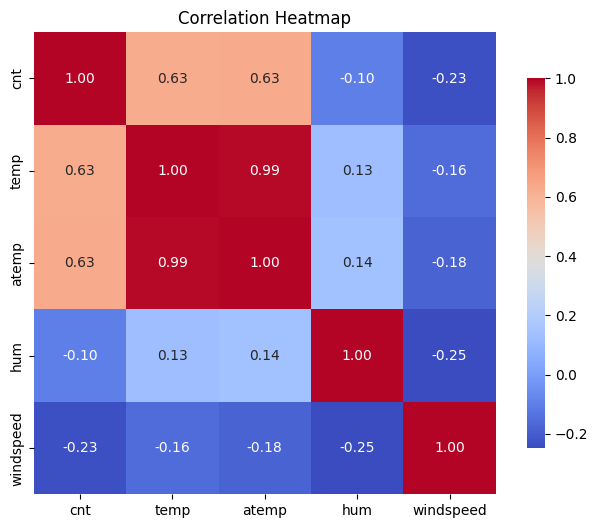

In [39]:
# Select numeric columns for correlation
numeric_cols = ['cnt', 'temp', 'atemp', 'hum', 'windspeed']

# Compute the correlation matrix
correlation_matrix = data[numeric_cols].corr()

# Create the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap")
plt.show()


In [40]:
data = data.drop(columns=['dteday'], errors='ignore')
X = data.drop(columns=['cnt'])

y = data['cnt']
X = sm.add_constant(X)
model1 = sm.OLS(y, X).fit()
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     91.84
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          9.27e-105
Time:                        23:18:10   Log-Likelihood:                -6313.1
No. Observations:                 731   AIC:                         1.264e+04
Df Residuals:                     722   BIC:                         1.269e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3178.4485    364.575      8.718      0.0

In [41]:
# Create polynomial features for 'temp'
poly = PolynomialFeatures(degree=4, include_bias=False)
temp_poly = poly.fit_transform(data[['temp']])
#temp_poly_df = pd.DataFrame(temp_poly, columns=['temp', 'temp^2','temp^3'])
temp_poly_df = pd.DataFrame(temp_poly, columns=['temp', 'temp^2', 'temp^3', 'temp^4'])
# Drop original 'temp' and replace with polynomial terms
X = X.drop(columns=['temp']).reset_index(drop=True)  # Reset index to avoid misalignment
X = pd.concat([X, temp_poly_df.reset_index(drop=True)], axis=1)  # Ensure alignment

# Fit the updated OLS model
model2 = sm.OLS(y.reset_index(drop=True), X).fit()  # Reset 'y' index to align with 'X'
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     100.9
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.15e-137
Time:                        23:18:10   Log-Likelihood:                -6228.5
No. Observations:                 731   AIC:                         1.248e+04
Df Residuals:                     719   BIC:                         1.254e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4277.2195   1247.528      3.429      0.0

In [42]:
# Residual Sum of Squares (RSS) and RSE for Model 1 & 2
RSS_model1 = sum(model1.resid ** 2)
RSE_model1 = (RSS_model1 / model1.df_resid) ** 0.5
print(f"Model 1 Residual Standard Error (RSE): {RSE_model1}")

RSS_model2 = sum(model2.resid ** 2)
RSE_model2 = (RSS_model2 / model2.df_resid) ** 0.5
print(f"Model 2 Residual Standard Error (RSE): {RSE_model2}")


Model 1 Residual Standard Error (RSE): 1371.3590845146396
Model 2 Residual Standard Error (RSE): 1223.8926769187415


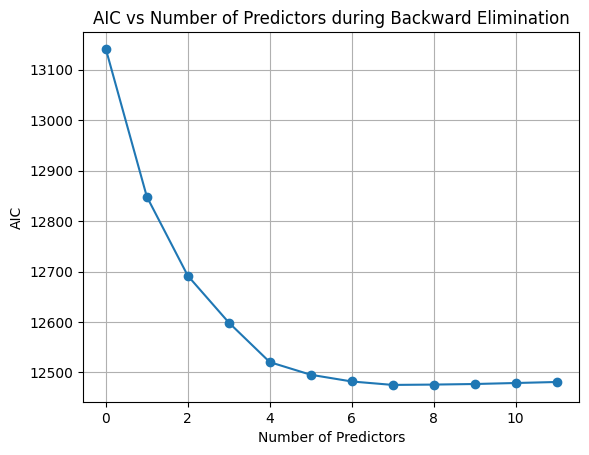

In [43]:

def Aic_progression(X, y):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    # Add constant for intercept term
    X = sm.add_constant(X)
    
    # Store AIC values and number of predictors
    aic_values = []
    predictors_count = []

    # Start with the full model (all predictors, including intercept)
    current_X = X.copy()
    model = sm.OLS(y, current_X).fit()
    current_aic = model.aic
    aic_values.append(current_aic)
    predictors_count.append(current_X.shape[1] - 1)  # Exclude intercept term from count

    # Perform backward elimination
    while current_X.shape[1] > 1:  # Keep iterating until only one predictor (intercept) remains
        aic_per_predictor = {}

        # Test AIC by removing each predictor
        for predictor in current_X.columns[1:]:  # Skip intercept term
            temp_X = current_X.drop(columns=[predictor])
            temp_model = sm.OLS(y, temp_X).fit()
            aic_per_predictor[predictor] = temp_model.aic

        # Find the predictor whose removal results in the lowest AIC
        best_predictor = min(aic_per_predictor, key=aic_per_predictor.get)
        best_aic = aic_per_predictor[best_predictor]

        # If removing the predictor reduces AIC, remove it
        current_X = current_X.drop(columns=[best_predictor])
        model = sm.OLS(y, current_X).fit()
        current_aic = best_aic

        # Store new AIC and number of predictors (exclude intercept from count)
        aic_values.append(current_aic)
        predictors_count.append(current_X.shape[1] - 1)  # Exclude intercept term from count

    # Return AIC values and number of predictors for plotting
    return aic_values, predictors_count

# Perform backward elimination and get AIC values and predictor counts
aic_values, predictors_count = Aic_progression(X, y)

# Plot AIC vs Number of Predictors
plt.plot(predictors_count, aic_values, marker='o')
plt.xlabel('Number of Predictors')
plt.ylabel('AIC')
plt.title('AIC vs Number of Predictors during Backward Elimination')
plt.grid(True)
plt.show()



In [44]:
def backward_elimination_aic(X, y):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    # Fit the initial model
    model = sm.OLS(y, X).fit()
    current_aic = model.aic

    while True:
        aic_values = {}

        # Test AIC by removing each predictor
        for predictor in X.columns[1:]:  # Skip intercept
            temp_X = X.drop(columns=[predictor])
            temp_model = sm.OLS(y, temp_X).fit()
            aic_values[predictor] = temp_model.aic

        # Find the predictor whose removal results in the lowest AIC
        if aic_values:
            best_predictor = min(aic_values, key=aic_values.get)
            best_aic = aic_values[best_predictor]

            # If removing the predictor reduces AIC, remove it
            if best_aic < current_aic:
                print(f"Dropping {best_predictor} (AIC = {best_aic:.4f})")
                X = X.drop(columns=[best_predictor])
                current_aic = best_aic
                model = sm.OLS(y, X).fit()
            else:
                break
        else:
            break

    # Return both the final model and predictors
    return model, X

# Perform backward elimination
final_model, final_X = backward_elimination_aic(X, y)

print(final_model.summary())


Dropping temp^4 (AIC = 12478.9045)
Dropping atemp (AIC = 12476.9149)
Dropping temp (AIC = 12475.7783)
Dropping workingday (AIC = 12475.0980)
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     158.7
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.71e-141
Time:                        23:18:10   Log-Likelihood:                -6229.5
No. Observations:                 731   AIC:                         1.248e+04
Df Residuals:                     723   BIC:                         1.251e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025   

In [45]:
RSS_model_F = sum(final_model.resid ** 2)
RSE_model_F = (RSS_model_F / final_model.df_resid) ** 0.5
print(f"Model 3 Residual Standard Error (RSE): {RSE_model_F}")

Model 3 Residual Standard Error (RSE): 1222.3352468580576


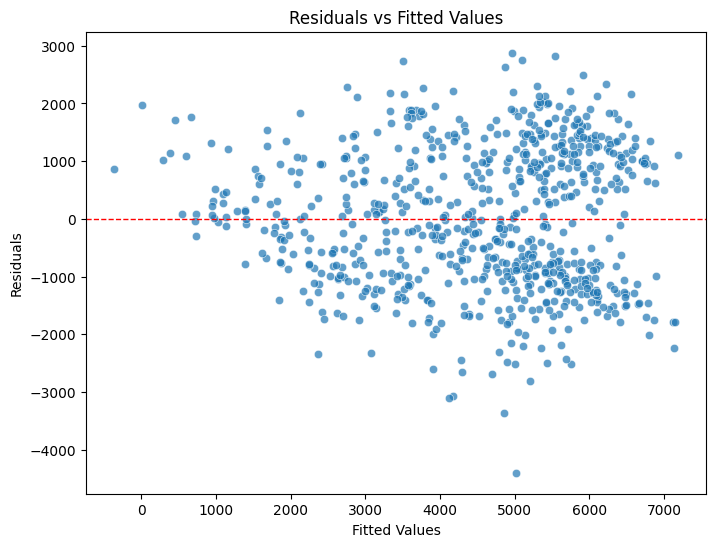

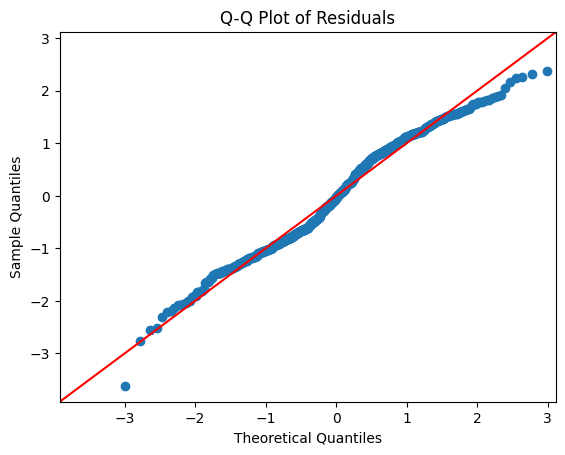

      Feature        VIF
0       const  43.170355
1        mnth   1.134938
2     weekday   1.010361
3  weathersit   1.729158
4         hum   1.953945
5   windspeed   1.177096
6      temp^2  58.850647
7      temp^3  58.184566


In [46]:
# Final model predictors
selected_features = final_model.model.exog_names  # Includes 'const'
selected_features = [f for f in selected_features if f != 'const']

# Residual plots
fitted_values = final_model.fittedvalues
residuals = final_model.resid

# 1. Residual vs. Fitted Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted_values, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# 3. Q-Q Plot
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# 4. Multicollinearity Check: VIF
X_selected = sm.add_constant(X[selected_features])  # Subset of X used in the final model
vif_data = pd.DataFrame({
    'Feature': X_selected.columns,
    'VIF': [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]
})
print(vif_data)